# Unsupervised Learning - Statistical Features and K-means Clustering

In [28]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_processing import (
    getDatasets,
    create_statistical_features,
    perform_kmeans_clustering
)

## Load Data and Identify Sensor Columns

In [29]:
# Load datasets
datasets = getDatasets()
print(f"Loaded {len(datasets)} PVS datasets")

# Use PVS 1 for analysis
pvs_data = datasets['pvs_1']
left_data = pvs_data['data_left']
right_data = pvs_data['data_right']
labels = pvs_data['data_labels']

# Identify sensor columns
sensor_columns = [col for col in left_data.columns if any(x in col.lower() for x in ['acc_', 'gyro_', 'mag_'])]
print(f"Found {len(sensor_columns)} sensor columns")
print(f"Examples: {sensor_columns[:5]}")

Loaded 9 PVS datasets
Found 24 sensor columns
Examples: ['acc_x_dashboard', 'acc_y_dashboard', 'acc_z_dashboard', 'acc_x_above_suspension', 'acc_y_above_suspension']


## Create Statistical Features

In [30]:
# Create statistical features with window size 50
window_size = 50

# Extract features from left and right sensor data
left_features = create_statistical_features(left_data, sensor_columns, window_size)
right_features = create_statistical_features(right_data, sensor_columns, window_size)

# Combine features from both sides
combined_features = pd.concat([left_features, right_features.add_suffix('_right')], axis=1)

print(f"Created {combined_features.shape[1]} statistical features")
print(f"Data shape: {combined_features.shape}")
print(f"Sample features: {list(combined_features.columns[:6])}")

Created 144 statistical features
Data shape: (144036, 144)
Sample features: ['acc_x_dashboard_mean', 'acc_x_dashboard_std', 'acc_x_dashboard_var', 'acc_y_dashboard_mean', 'acc_y_dashboard_std', 'acc_y_dashboard_var']


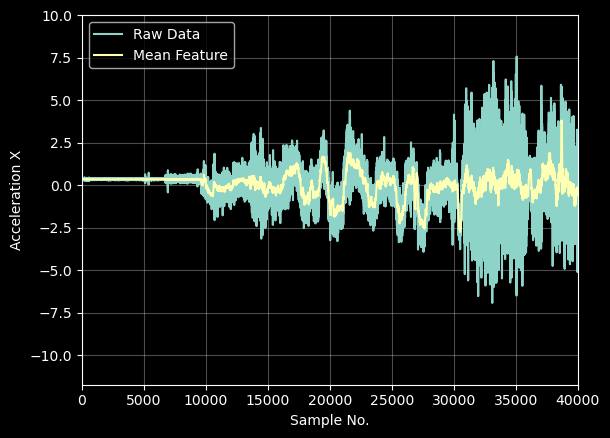

In [31]:
plt.plot(range(len(left_data.acc_x_dashboard)), left_data.acc_x_dashboard)
plt.plot(range(len(left_features.acc_x_dashboard_mean)), left_features.acc_x_dashboard_mean)
plt.xlabel('Sample No.')
plt.ylabel('Acceleration X')
plt.legend(['Raw Data', 'Mean Feature'])
plt.grid(True, alpha=0.3)
plt.xlim(0, 40000)
plt.show()

## Perform K-means Clustering

In [32]:
# Perform k-means clustering with 3 clusters
n_clusters = 3
mean_feature_cols = [col for col in combined_features.columns if col.endswith('_mean')]
cluster_labels, kmeans_model = perform_kmeans_clustering(combined_features[mean_feature_cols], n_clusters)

# Show cluster distribution
unique, counts = np.unique(cluster_labels, return_counts=True)
print(f"K-means clustering with {n_clusters} clusters:")
for cluster, count in zip(unique, counts):
    percentage = (count / len(cluster_labels)) * 100
    print(f"  Cluster {cluster}: {count} samples ({percentage:.1f}%)")

# Add cluster labels to the data
results_df = combined_features.copy()
results_df['cluster'] = cluster_labels

K-means clustering with 3 clusters:
  Cluster 0: 39139 samples (27.2%)
  Cluster 1: 45822 samples (31.8%)
  Cluster 2: 59075 samples (41.0%)


## Visualize Clusters and Analyze Patterns

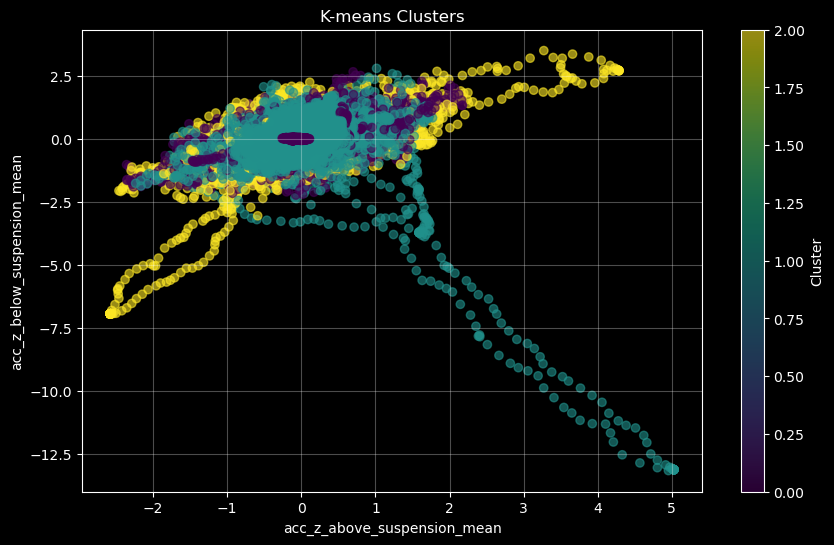


Cluster distribution by road surface:
dirt_road: [10.4, 33.2, 11.1]% have this surface by cluster
cobblestone_road: [59.5, 25.8, 44.9]% have this surface by cluster
asphalt_road: [30.0, 41.0, 44.0]% have this surface by cluster


In [33]:
# Visualize clusters using first two features
feature1 = combined_features.columns[15]
feature2 = combined_features.columns[24]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(combined_features[feature1]-9.81, combined_features[feature2]-9.81, 
                     c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('K-means Clusters')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# Analyze relationship to road conditions
labels_with_clusters = labels.copy()
labels_with_clusters['cluster'] = cluster_labels

print("\nCluster distribution by road surface:")
road_surfaces = ['dirt_road', 'cobblestone_road', 'asphalt_road']
for surface in road_surfaces:
    surface_clusters = labels_with_clusters.groupby(['cluster', surface]).size().unstack(fill_value=0)
    surface_pct = surface_clusters.div(surface_clusters.sum(axis=1), axis=0) * 100
    print(f"{surface}: {surface_pct[1].round(1).tolist()}% have this surface by cluster")

In [34]:
# Compute per-surface and per-cluster accuracy (concise)
surface_cols = road_surfaces  # ['dirt_road', 'cobblestone_road', 'asphalt_road']

# DataFrame with only surface labels and cluster assignments
lwc = labels_with_clusters.loc[:, surface_cols + ['cluster']]

# Single ground-truth surface per sample
true_surface = lwc[surface_cols].idxmax(axis=1)

# Contingency tables - frequency table counting occurrences of each surface in each cluster
ct_cluster_by_surface = pd.crosstab(lwc['cluster'], true_surface)   # rows: cluster, cols: surface

# Most common surface within each cluster (percentage accuracy per cluster)
cluster_accuracy = pd.DataFrame({
    'best_surface': ct_cluster_by_surface.idxmax(axis=1),
    'accuracy_pct': (ct_cluster_by_surface.max(axis=1) / ct_cluster_by_surface.sum(axis=1) * 100).round(2)
})

print("\nAccuracy per cluster (%):")
print(cluster_accuracy)


Accuracy per cluster (%):
             best_surface  accuracy_pct
cluster                                
0        cobblestone_road         59.55
1            asphalt_road         41.01
2        cobblestone_road         44.90


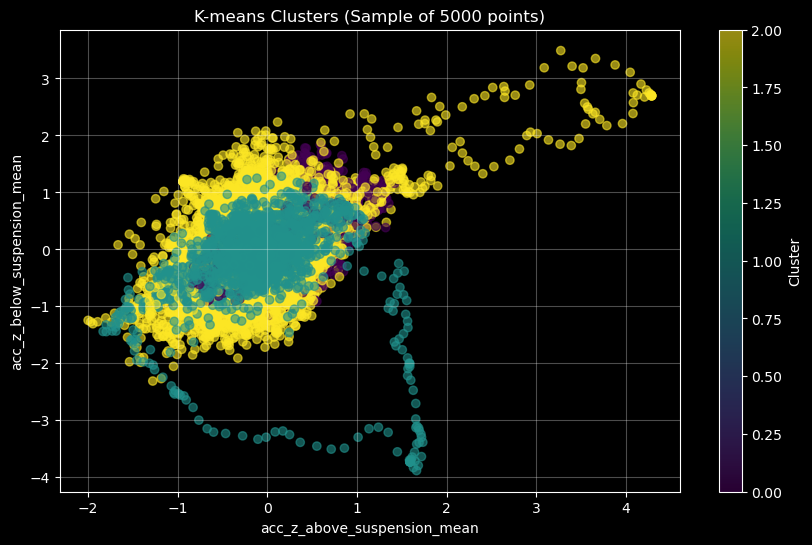

In [35]:
# Test visualization
feature1 = combined_features.columns[15]
feature2 = combined_features.columns[24]

# Use a sample for visualization (first 5000 points for speed)
sample_size = 40000
sample_features = combined_features.iloc[:sample_size]
sample_labels = cluster_labels[:sample_size]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(sample_features[feature1]-9.81, sample_features[feature2]-9.81, 
                     c=sample_labels, cmap='viridis', alpha=0.6)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('K-means Clusters (Sample of 5000 points)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()